In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 8.9 MB/s eta 0:00:00


In [ ]:
import torch
import tqdm
import numpy as np
import pandas as pd
import gpytorch
from torch.nn import Linear
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel, MaternKernel, AdditiveKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
#Path to Feature CSV
features_df = pd.read_csv('EEW_features_combined.csv')
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
       ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
               ' ddt_PVd ', ' ddt_PAd ']
label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV ']

epsilon = 1e-7
feature_data = np.log10(np.where(np.isnan(features_df[feature_list].values) | (features_df[feature_list].values < 0), 0, features_df[feature_list].values) + epsilon)
label_data = np.log10(np.nan_to_num(features_df[label_list].values, nan=0.0) + epsilon)

In [ ]:
features_df.head()

,filename,date,time,Rmag,Rdpth,Rlat,Rlon,Station,Sheight,Slat,...,ddt_PVd,ddt_PAd,ddt_PDt,ddt_PVt,ddt_PAt,PGA,PGV,tPGA,tPGV,RSdistance
0,AKT0020112022202.EW,2001/12/02,22:02:00,6.4,122.0,39.398,141.263,AKT002,80.0,40.2677,...,0.22715,2.72814,0.10198,0.53131,4.10324,76.460,13.092,29.32,29.67,NaN
1,AKT0030112022202.EW,2001/12/02,22:02:00,6.4,122.0,39.398,141.263,AKT003,37.0,40.2782,...,0.13723,1.83743,0.10855,0.44765,3.11619,37.999,7.908,30.95,31.44,NaN
2,AKT0040112022202.EW,2001/12/02,22:02:00,6.4,122.0,39.398,141.263,AKT004,31.0,40.3888,...,0.18880,2.98512,0.0823,0.29506,1.38124,20.364,3.938,22.63,22.46,NaN
3,AKT0050112022202.EW,2001/12/02,22:02:00,6.4,122.0,39.398,141.263,AKT005,10.0,40.2032,...,1.07782,5.53507,-0.08266,-0.08523,1.15604,60.830,11.764,22.35,22.15,NaN
4,AKT0060112022202.EW,2001/12/02,22:02:00,6.4,122.0,39.398,141.263,AKT006,120.0,40.2152,...,0.31312,5.79138,0.07642,0.30409,6.77991,89.649,14.965,28.77,21.74,NaN


In [ ]:
print(len(feature_data))

31200


In [ ]:
print(feature_data[:5])

[[ 1.75975092e+00  7.89016334e-01 -8.61860947e-02 -3.14885441e-01
  -1.19014952e-01 -1.08607971e+00 -6.97127948e-01  4.03444851e-01
  -2.94743613e-01  3.83174237e-01  1.29319433e+00 -1.70245614e+00
  -6.43687068e-01  4.35866669e-01]
 [ 1.90615719e+00  9.12965626e-01  4.53230179e-02 -4.65339297e-01
  -1.42365955e-01 -1.65208286e+00 -7.89788261e-01  3.49213418e-01
  -3.53145449e-01  2.78559291e-01  1.15610979e+00 -1.84133301e+00
  -8.62550620e-01  2.64210827e-01]
 [ 1.72352955e+00  7.70189030e-01  4.34294460e-08 -4.53827508e-01
  -4.38795656e-02 -1.60310181e+00 -6.91414032e-01  5.08535119e-01
  -4.51843947e-01  1.40130810e-01  9.41321579e-01 -1.82102018e+00
  -7.23997780e-01  4.74961809e-01]
 [ 1.74664977e+00  9.27985952e-01  4.62398013e-01 -2.04515798e-02
  -2.11805677e-02 -6.36370301e-02  4.98825900e-01  1.21501330e+00
  -1.60559601e-01  4.73574565e-01  1.27467800e+00 -5.31888937e-01
   3.25462784e-02  7.43123125e-01]
 [ 1.89068364e+00  1.44512139e+00 -4.57574423e-02 -5.92438981e-01
  

In [ ]:
def calculate_accuracy(predicted_means, predicted_vars, test_y, alpha):
    num_tasks = predicted_means.shape[1]
    accuracies = []

    for i in range(num_tasks):
        means = predicted_means[:, i]
        vars = predicted_vars[:, i]
        test_values = test_y[:, i]

        std_devs = np.sqrt(vars)
        lower_bounds = means - alpha*std_devs
        upper_bounds = means + alpha*std_devs

        correct_predictions = (test_values >= lower_bounds) & (test_values <= upper_bounds)
        accuracy = np.mean(correct_predictions)
        accuracies.append(accuracy)

    return accuracies

#Construct a layer: initialize + forward
class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=256, linear_mean=True):
        #Inducing points are points in input space that act as a representative summary for the entire dataset.
        #They make GP models scalable to larger datasets (optimized during training)
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])
        #Choose CVD since exact inference can be computationally prohibitive
        #Approximates the true posterior distribution with a multivariate normal distribution
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        #Defines how to propagate approximations through the model
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)

        rbf_kernel = RBFKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        linear_kernel = LinearKernel(ard_num_dims=input_dims, batch_shape=batch_shape)
        matern_kernel = MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims)
        additive_kernel = AdditiveKernel(rbf_kernel, matern_kernel)
        self.covar_module = ScaleKernel(matern_kernel, batch_shape=batch_shape, ard_num_dims = None)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [ ]:
#Construct a model: initiliaze + build architecture and forward
class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape,output_dims):
        #Initialize some stuff
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.num_layers = len(output_dims)
        #Given output_dims, which specifies the architecture of the network, we create it
        for i in range(len(output_dims)):
            if(i == 0):
                #first layer
                layer = DGPHiddenLayer(input_dims=train_x_shape[-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
            else:
                #hidden layers
                layer = DGPHiddenLayer(input_dims=output_dims[i-1],output_dims=output_dims[i],linear_mean=True)
                self.layers.append(layer)
        #last layer
        self.last_layer = DGPHiddenLayer(input_dims=output_dims[-1],output_dims=num_tasks,linear_mean=False)
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)


    def forward(self, inputs):
        #just propagating data through the network. go look at DGPHiddenLayer's forward function for unneceasry details
        rep = inputs
        for i, layer in enumerate(self.layers):
            rep = layer(rep)
        output = self.last_layer(rep)
        return output


    def predict(model, test_x):
        batch_size = 100
        n = test_x.size(0)
        means_list = []
        variances_list = []

        with torch.no_grad():
            for i in range(0, n, batch_size):
                batch_x = test_x[i:i + batch_size]
                preds = model.likelihood(model(batch_x)).to_data_independent_dist()
                means_list.append(preds.mean.mean(0))
                variances_list.append(preds.variance.mean(0))

        means = torch.cat(means_list)
        variances = torch.cat(variances_list)

        return means, variances

In [ ]:
X = feature_data
Y = label_data

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.224, shuffle= False, random_state = 42)#True, random_state=42)

In [ ]:
train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.float32).to(device)
print(train_x.shape)
output_dims = [2]
print(output_dims)
print(train_y.shape[-1])

torch.Size([24211, 14])
[2]
4


<ipython-input-32-4f8385c67735>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_x = torch.tensor(train_x, dtype=torch.float32).to(device)
<ipython-input-32-4f8385c67735>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y = torch.tensor(train_y, dtype=torch.float32).to(device)


In [ ]:
num_tasks = train_y.shape[-1]
#OUTPUTDIM IS VERY IMPORTANT -> YOU DECIDE THE ARCHITECTURE OF THE MODEL HERE
#if: output_dim = [n_0,n_1,....,n_i]
#then: k belongs to the interval [1,i], a subset of N
#n_k means that the kth layer has n_k outputs (similarly, it takes in n_(k-1) inputs)
#the last layer is not defined with output_dims, since the number of its outputs depends on the problem
output_dims = [2]
model = MultitaskDeepGP(train_x.shape,output_dims).to(device)
model.train()
#Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#ELBO measures how close variational distribution is to true posterior, so training a model with variational inference => maximize ELBO
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=train_y.shape[0]))

#Matern: 0.0401 -> LEVELS OUT AROUND 600
#linear kerne：0.25 -> levels around 300
num_epochs = 500
epochs_iter = tqdm.tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    #reset gradients
    optimizer.zero_grad()
    #get output and all the other regular ml stuff
    output = model(train_x)
    loss = -mll(output, train_y)
    if i % 10 == 0:
      print(f"Epoch {i}: Loss = {loss.item()}")

    if loss.item()<=0:
      break
    epochs_iter.set_postfix(loss=loss.item())
    #backprop
    loss.backward()
    #update
    optimizer.step()

Epoch:   0%|          | 0/500 [00:00<?, ?it/s, loss=7.24]

Epoch 0: Loss = 7.239476203918457


Epoch:   2%|▏         | 11/500 [00:18<14:01,  1.72s/it, loss=5.84]

Epoch 10: Loss = 5.843275547027588


Epoch:   4%|▍         | 21/500 [00:35<13:54,  1.74s/it, loss=5.18]

Epoch 20: Loss = 5.180696487426758


Epoch:   6%|▌         | 31/500 [00:52<13:36,  1.74s/it, loss=4.8]

Epoch 30: Loss = 4.798125743865967


Epoch:   8%|▊         | 41/500 [01:10<13:18,  1.74s/it, loss=4.55]

Epoch 40: Loss = 4.54995059967041


Epoch:  10%|█         | 51/500 [01:27<12:58,  1.73s/it, loss=4.35]

Epoch 50: Loss = 4.351054668426514


Epoch:  12%|█▏        | 61/500 [01:45<12:42,  1.74s/it, loss=4.16]

Epoch 60: Loss = 4.15858793258667


Epoch:  14%|█▍        | 71/500 [02:02<12:26,  1.74s/it, loss=3.93]

Epoch 70: Loss = 3.925191640853882


Epoch:  16%|█▌        | 81/500 [02:19<12:08,  1.74s/it, loss=3.67]

Epoch 80: Loss = 3.666168689727783


Epoch:  18%|█▊        | 91/500 [02:37<11:51,  1.74s/it, loss=3.43]

Epoch 90: Loss = 3.4254212379455566


Epoch:  20%|██        | 101/500 [02:54<11:32,  1.74s/it, loss=3.21]

Epoch 100: Loss = 3.205177068710327


Epoch:  22%|██▏       | 111/500 [03:12<11:16,  1.74s/it, loss=3]

Epoch 110: Loss = 2.9956040382385254


Epoch:  24%|██▍       | 121/500 [03:29<10:58,  1.74s/it, loss=2.79]

Epoch 120: Loss = 2.7938649654388428


Epoch:  26%|██▌       | 131/500 [03:46<10:41,  1.74s/it, loss=2.6]

Epoch 130: Loss = 2.5965030193328857


Epoch:  28%|██▊       | 141/500 [04:04<10:23,  1.74s/it, loss=2.4]

Epoch 140: Loss = 2.4034903049468994


Epoch:  30%|███       | 151/500 [04:21<10:05,  1.74s/it, loss=2.21]

Epoch 150: Loss = 2.213245391845703


Epoch:  32%|███▏      | 161/500 [04:38<09:49,  1.74s/it, loss=2.03]

Epoch 160: Loss = 2.028891086578369


Epoch:  34%|███▍      | 171/500 [04:56<09:32,  1.74s/it, loss=1.85]

Epoch 170: Loss = 1.853359580039978


Epoch:  36%|███▌      | 181/500 [05:13<09:14,  1.74s/it, loss=1.69]

Epoch 180: Loss = 1.6852344274520874


Epoch:  38%|███▊      | 191/500 [05:31<08:57,  1.74s/it, loss=1.52]

Epoch 190: Loss = 1.52398681640625


Epoch:  40%|████      | 201/500 [05:48<08:40,  1.74s/it, loss=1.37]

Epoch 200: Loss = 1.3722331523895264


Epoch:  42%|████▏     | 211/500 [06:05<08:22,  1.74s/it, loss=1.23]

Epoch 210: Loss = 1.2278894186019897


Epoch:  44%|████▍     | 221/500 [06:23<08:05,  1.74s/it, loss=1.09]

Epoch 220: Loss = 1.0942821502685547


Epoch:  46%|████▌     | 231/500 [06:40<07:47,  1.74s/it, loss=0.968]

Epoch 230: Loss = 0.9683986902236938


Epoch:  48%|████▊     | 241/500 [06:58<07:30,  1.74s/it, loss=0.855]

Epoch 240: Loss = 0.8545989394187927


Epoch:  50%|█████     | 251/500 [07:15<07:12,  1.74s/it, loss=0.749]

Epoch 250: Loss = 0.7493062615394592


Epoch:  52%|█████▏    | 261/500 [07:32<06:55,  1.74s/it, loss=0.654]

Epoch 260: Loss = 0.6535741686820984


Epoch:  54%|█████▍    | 271/500 [07:50<06:38,  1.74s/it, loss=0.567]

Epoch 270: Loss = 0.5674543976783752


Epoch:  56%|█████▌    | 281/500 [08:07<06:20,  1.74s/it, loss=0.491]

Epoch 280: Loss = 0.4906771779060364


Epoch:  58%|█████▊    | 291/500 [08:24<06:02,  1.74s/it, loss=0.421]

Epoch 290: Loss = 0.4207479655742645


Epoch:  60%|██████    | 301/500 [08:42<05:45,  1.74s/it, loss=0.362]

Epoch 300: Loss = 0.36167478561401367


Epoch:  62%|██████▏   | 311/500 [08:59<05:28,  1.74s/it, loss=0.307]

Epoch 310: Loss = 0.30748531222343445


Epoch:  64%|██████▍   | 321/500 [09:17<05:11,  1.74s/it, loss=0.255]

Epoch 320: Loss = 0.25543537735939026


Epoch:  66%|██████▌   | 331/500 [09:34<04:53,  1.74s/it, loss=0.211]

Epoch 330: Loss = 0.2105688601732254


Epoch:  68%|██████▊   | 341/500 [09:51<04:36,  1.74s/it, loss=0.171]

Epoch 340: Loss = 0.1707787960767746


Epoch:  70%|███████   | 351/500 [10:09<04:19,  1.74s/it, loss=0.138]

Epoch 350: Loss = 0.13810375332832336


Epoch:  72%|███████▏  | 361/500 [10:26<04:01,  1.74s/it, loss=0.107]

Epoch 360: Loss = 0.10656757652759552


Epoch:  74%|███████▍  | 371/500 [10:44<03:43,  1.74s/it, loss=0.0795]

Epoch 370: Loss = 0.07945498079061508


Epoch:  76%|███████▌  | 381/500 [11:01<03:26,  1.74s/it, loss=0.0579]

Epoch 380: Loss = 0.05789076164364815


Epoch:  78%|███████▊  | 391/500 [11:18<03:09,  1.74s/it, loss=0.0319]

Epoch 390: Loss = 0.031877268105745316


Epoch:  80%|████████  | 401/500 [11:36<02:52,  1.74s/it, loss=0.0121]

Epoch 400: Loss = 0.012141863815486431


Epoch:  81%|████████  | 406/500 [11:46<02:43,  1.74s/it, loss=0.000176]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
model.eval()
model.likelihood.eval()
test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.float32).cpu().numpy()
#redict on the test data
predicted_means, predicted_vars = model.predict(test_x)
predicted_means = predicted_means.cpu().numpy()
predicted_vars = predicted_vars.cpu().numpy()


#Multitask outputs -> compute metrics for each output separately
alpha = 1.5
mse_list = []
r2_list = []
for i in range(num_tasks):
    mse = mean_squared_error(test_y[:, i], predicted_means[:, i])
    r2 = r2_score(test_y[:, i], predicted_means[:, i])
    mse_list.append(mse)
    r2_list.append(r2)
accuracy_list = calculate_accuracy(predicted_means, predicted_vars, test_y, alpha)

print("MSE for each task:", mse_list)
print("R2 for each task:", r2_list)
print("Accuracy for each task", accuracy_list)

MSE for each task: [0.106514856, 0.14009139, 0.033047035, 0.026946861]
R2 for each task: [0.7908421754837036, 0.6316338777542114, 0.38442063331604004, 0.43997442722320557]
Accuracy for each task [0.8273000429245958, 0.8052654170839891, 0.9596508799542137, 0.966661897267134]


In [ ]:
model.eval()
model.likelihood.eval()
test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.float32).cpu().numpy()
#redict on the test data
predicted_means, predicted_vars = model.predict(test_x)
predicted_means = predicted_means.cpu().numpy()
predicted_vars = predicted_vars.cpu().numpy()


#Multitask outputs -> compute metrics for each output separately
alpha = 1.5
mse_list = []
r2_list = []
for i in range(num_tasks):
    mse = mean_squared_error(test_y[:, i], predicted_means[:, i])
    r2 = r2_score(test_y[:, i], predicted_means[:, i])
    mse_list.append(mse)
    r2_list.append(r2)
accuracy_list = calculate_accuracy(predicted_means, predicted_vars, test_y, alpha)

print("MSE for each task:", mse_list)
print("R2 for each task:", r2_list)
print("Accuracy for each task", accuracy_list)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


MSE for each task: [0.1815376, 0.18410131, 0.084546074, 0.0734898]
R2 for each task: [0.6883114576339722, 0.5321497917175293, 0.05246305465698242, 0.10692447423934937]
Accuracy for each task [0.7790087463556852, 0.7801749271137026, 0.9329446064139941, 0.9615160349854227]


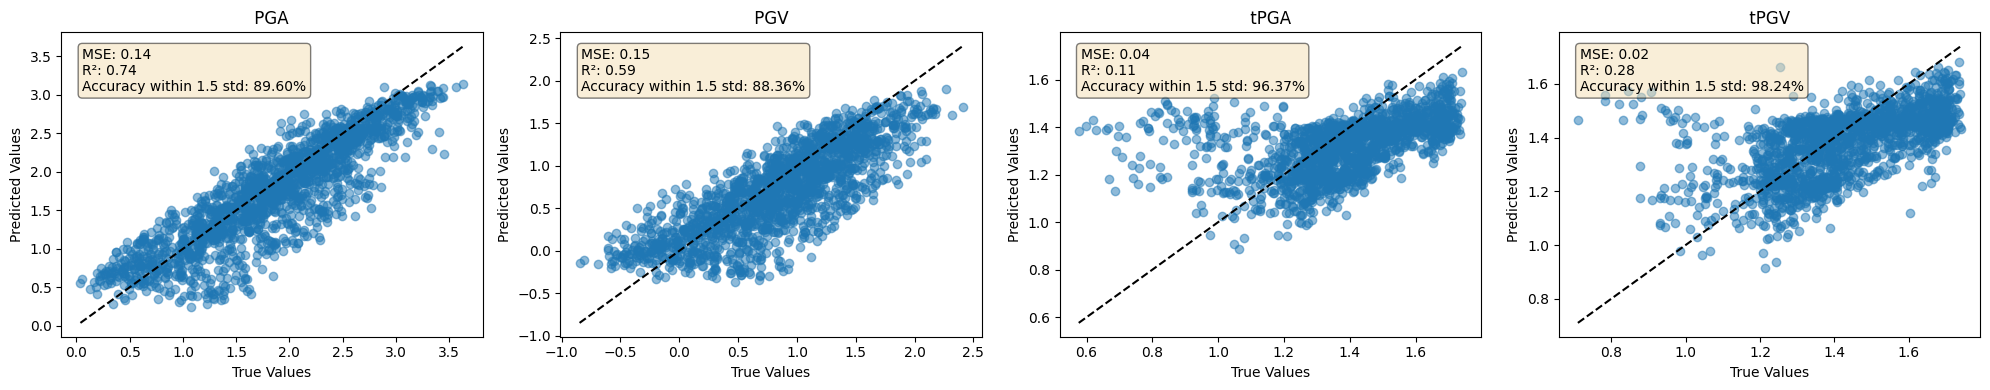

In [ ]:
label_no = test_y.shape[-1]
fig, axes = plt.subplots(nrows=1, ncols=label_no, figsize=(5 * label_no, 4))

# Set the threshold for outlier detection (e.g., 2 standard deviations)
outlier_threshold = 3

for i in range(label_no):
    # Calculate residuals and standard deviation
    residuals = test_y[:, i] - predicted_means[:, i]
    std_dev = np.std(residuals)

    # Identify inliers (within the threshold)
    inliers = np.abs(residuals) <= outlier_threshold * std_dev
    filtered_true = test_y[inliers, i]
    filtered_pred = predicted_means[inliers, i]

    # Plot inliers only
    ax = axes[i] if label_no > 1 else axes
    ax.scatter(filtered_true, filtered_pred, alpha=0.5)
    ax.set_title(f'{label_list[i]}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([filtered_true.min(), filtered_true.max()], [filtered_true.min(), filtered_true.max()], 'k--')

    # Update text with metrics based on inliers
    mse_inliers = np.mean((filtered_true - filtered_pred) ** 2)
    r2_inliers = 1 - (np.sum((filtered_true - filtered_pred) ** 2) / np.sum((filtered_true - np.mean(filtered_true)) ** 2))
    accuracy_inliers = np.mean(np.abs(filtered_true - filtered_pred) < alpha * std_dev)

    textstr = f'MSE: {mse_inliers:.2f}\nR²: {r2_inliers:.2f}\nAccuracy within {alpha} std: {accuracy_inliers:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

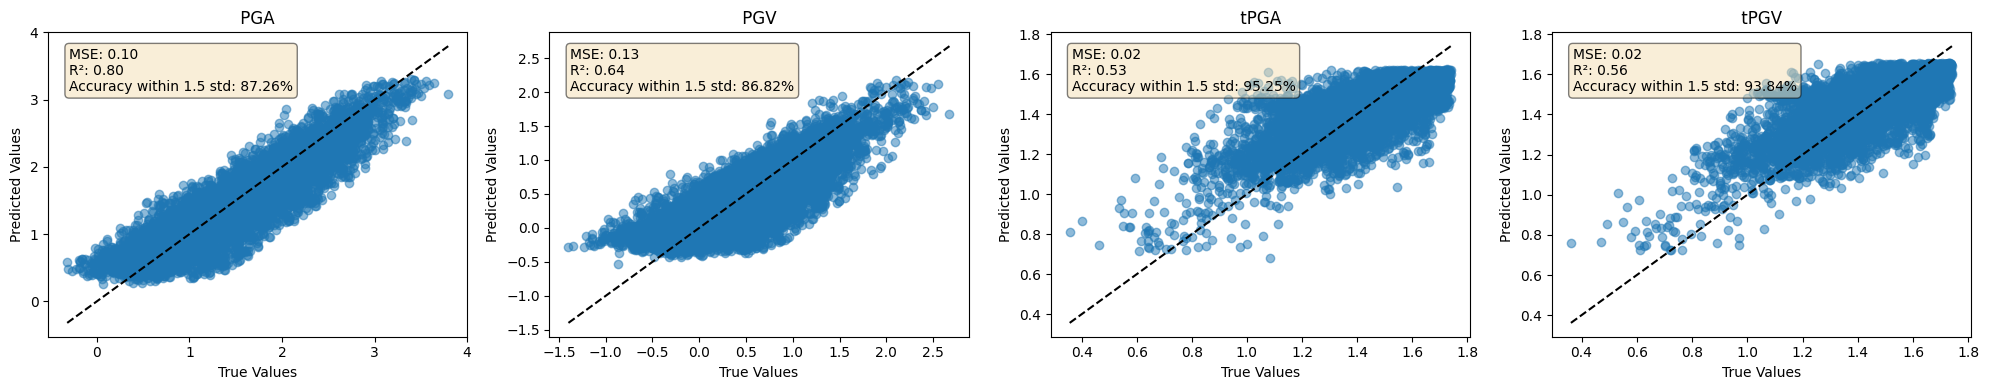

In [ ]:
label_no = test_y.shape[-1]
fig, axes = plt.subplots(nrows=1, ncols=label_no, figsize=(5 * label_no, 4))

# Set the threshold for outlier detection (e.g., 2 standard deviations)
outlier_threshold = 3

for i in range(label_no):
    # Calculate residuals and standard deviation
    residuals = test_y[:, i] - predicted_means[:, i]
    std_dev = np.std(residuals)

    # Identify inliers (within the threshold)
    inliers = np.abs(residuals) <= outlier_threshold * std_dev
    filtered_true = test_y[inliers, i]
    filtered_pred = predicted_means[inliers, i]

    # Plot inliers only
    ax = axes[i] if label_no > 1 else axes
    ax.scatter(filtered_true, filtered_pred, alpha=0.5)
    ax.set_title(f'{label_list[i]}')
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.plot([filtered_true.min(), filtered_true.max()], [filtered_true.min(), filtered_true.max()], 'k--')

    # Update text with metrics based on inliers
    mse_inliers = np.mean((filtered_true - filtered_pred) ** 2)
    r2_inliers = 1 - (np.sum((filtered_true - filtered_pred) ** 2) / np.sum((filtered_true - np.mean(filtered_true)) ** 2))
    accuracy_inliers = np.mean(np.abs(filtered_true - filtered_pred) < alpha * std_dev)

    textstr = f'MSE: {mse_inliers:.2f}\nR²: {r2_inliers:.2f}\nAccuracy within {alpha} std: {accuracy_inliers:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Define the folder path
folder_path = '/content/drive/My Drive/models'

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Define the file paths
model_path = os.path.join(folder_path, 'multitask_deepgp_model.pth')
likelihood_path = os.path.join(folder_path, 'multitask_likelihood.pth')

# Save the model and likelihood state dictionaries
torch.save(model.state_dict(), model_path)
torch.save(model.likelihood.state_dict(), likelihood_path)

In [ ]:
### CODE TO LOAD THE SAVED MODEL

import os
import torch

# Define the folder path
folder_path = '/content/drive/My Drive/models'

# Define the file paths
model_path = os.path.join(folder_path, 'multitask_deepgp_model.pth')
likelihood_path = os.path.join(folder_path, 'multitask_likelihood.pth')

# Reconstruct the model architecture
# You need to provide the same parameters as during training
train_x_shape = train_x.shape   # Replace with the actual shape used during training
output_dims = [2]     # Replace with the actual output dimensions used during training
num_tasks = train_y.shape[-1]     # Replace with the actual number of tasks

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = MultitaskDeepGP(train_x_shape, output_dims).to(device)
model.likelihood = model.likelihood.to(device)

# Load the state dictionaries
model.load_state_dict(torch.load(model_path, map_location=device))
model.likelihood.load_state_dict(torch.load(likelihood_path, map_location=device))

# Set the model to evaluation mode
model.eval()
model.likelihood.eval()

<ipython-input-38-be170b364047>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
<ipython-input-38-be170b

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [ ]:
model.eval()
model.likelihood.eval()
test_x = torch.tensor(test_x, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.float32).cpu().numpy()
#redict on the test data
predicted_means, predicted_vars = model.predict(test_x)
predicted_means = predicted_means.cpu().numpy()
predicted_vars = predicted_vars.cpu().numpy()


#Multitask outputs -> compute metrics for each output separately
alpha = 1.5
mse_list = []
r2_list = []
for i in range(num_tasks):
    mse = mean_squared_error(test_y[:, i], predicted_means[:, i])
    r2 = r2_score(test_y[:, i], predicted_means[:, i])
    mse_list.append(mse)
    r2_list.append(r2)
accuracy_list = calculate_accuracy(predicted_means, predicted_vars, test_y, alpha)

print("MSE for each task:", mse_list)
print("R2 for each task:", r2_list)
print("Accuracy for each task", accuracy_list)

<ipython-input-39-0b0f85b5406a>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_x = torch.tensor(test_x, dtype=torch.float32).to(device)


MSE for each task: [0.10657714, 0.14005743, 0.033099655, 0.026993234]
R2 for each task: [0.7907198667526245, 0.631723165512085, 0.38344043493270874, 0.4390106797218323]
Accuracy for each task [0.8268707969666619, 0.8062669909858349, 0.9609386178280155, 0.96694806123909]


## Deep Shapley for Model Explanability

In [ ]:
pip install shap

In [ ]:
class DGPModelWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, x):
        # Convert input data to a PyTorch tensor on GPU
        x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
        with torch.no_grad():
            means, _ = self.model.predict(x_tensor)  # Run model on GPU
        return means.cpu().numpy()  # Return result as NumPy array for SHAP

In [ ]:
import shap
# Move model to GPU
model.to(device)

# Convert a small subset of the training data to NumPy array on CPU for background data
background = train_x[:50].cpu().numpy()
test_x_np = test_x[:100].cpu().numpy()  # Convert test subset for SHAP compatibility

In [ ]:
# Initialize KernelExplainer with the DGP model wrapper and background data
explainer = shap.KernelExplainer(DGPModelWrapper(model), background)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(test_x_np)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print(shap_values.shape)

(100, 14, 4)


In [ ]:
print(test_x_np.shape)

(100, 14)


In [ ]:
print(shap_values[:,:,0].shape)

(100, 14)


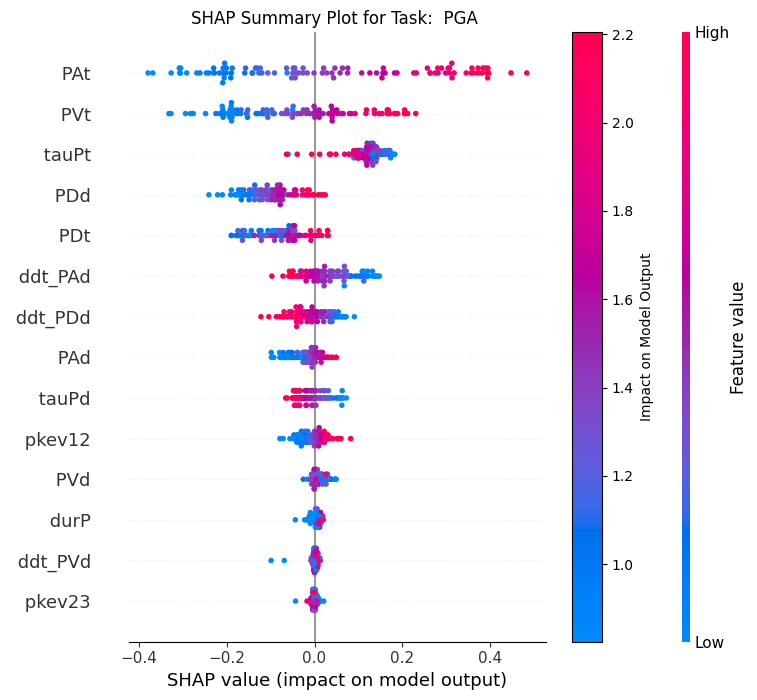

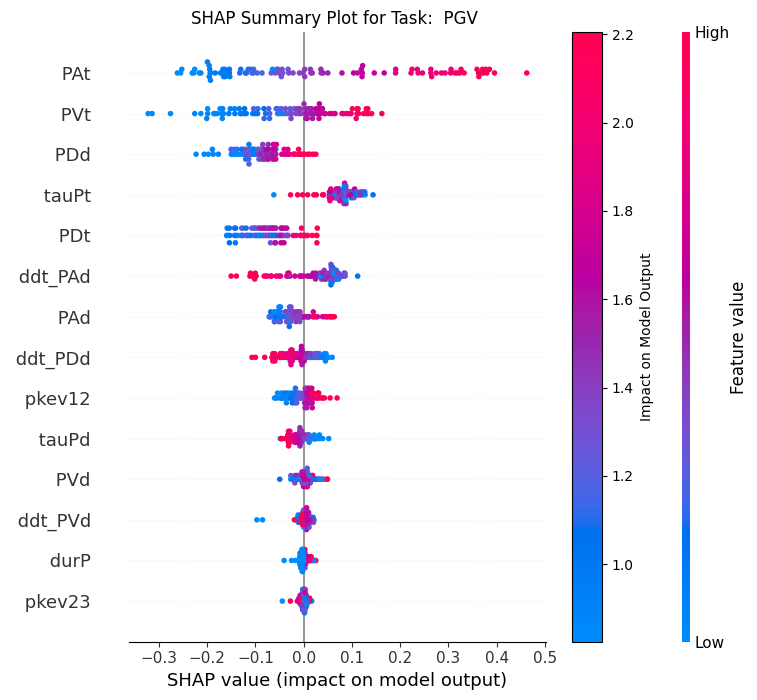

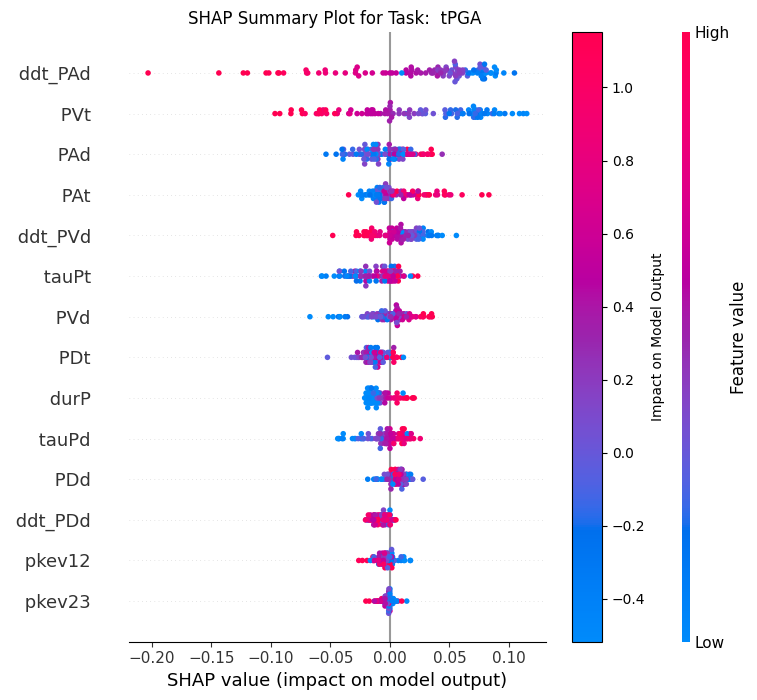

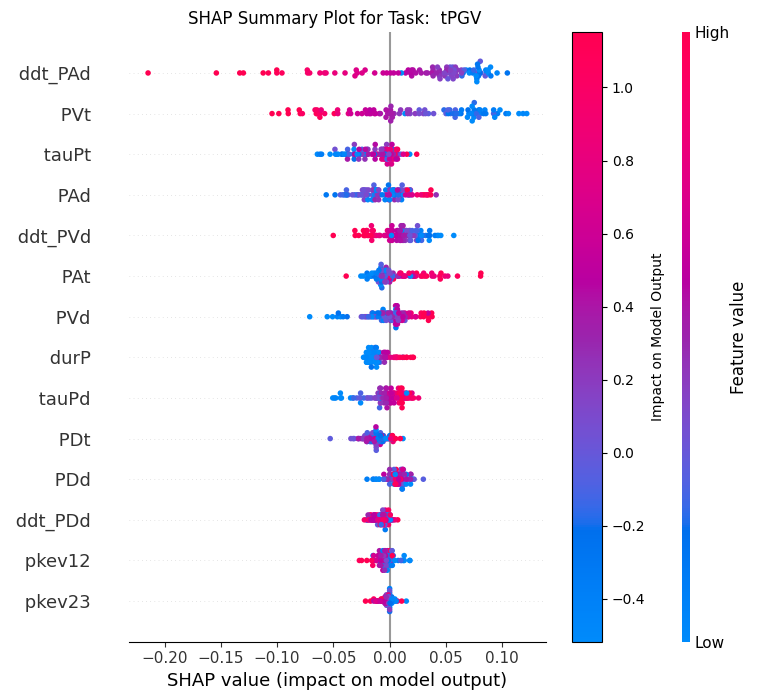

In [ ]:
feature_list = [' pkev12 ', ' pkev23 ', ' durP ', ' tauPd ', ' tauPt ',
       ' PDd ', ' PVd ', ' PAd ', ' PDt ', ' PVt ', ' PAt ', ' ddt_PDd ',
               ' ddt_PVd ', ' ddt_PAd ']
label_list = [' PGA ', ' PGV ', ' tPGA ', ' tPGV ']
for i, label in enumerate(label_list):
    shap.summary_plot(
        shap_values[:, :, i],
        test_x_np,
        feature_names=feature_list,
        show=False  # Prevents immediate display if in a loop for customization
    )
    plt.title(f"SHAP Summary Plot for Task: {label}")
    plt.colorbar(label="Impact on Model Output")
    plt.tight_layout()  # Optimizes spacing
    plt.show()